# Springboard Capstone Project 1 Final Submission

The problem is that in the NBA, the level of talent across the organizations is heavily skewed towards very few organizations, known as the "powerhouse" teams. With new rising talent and incoming prospects, it is critical that the organizations who have not been performing well over the past several years put some time into analyzing which types of players that their organization needs and which ones to invest in while the players are still young. 

Here is the code I am using for my final submission for my first capstone project. This includes code from previous submissions for my first project from data storytelling, inferential statistics, and machine learning.

In [1]:
# import all necessary libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
# for plotting, from springboard mini project

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [3]:
# useful functions for inferential statistics

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

def perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    concat_data = np.concatenate((data_1, data_2))

    for i in range(size):
        # Generate permutation sample
        perm_sample = np.random.permutation(concat_data)
        perm_1 = perm_sample[:len(data_1)]
        perm_2 = perm_sample[len(data_1):]

        # Compute the test statistic
        perm_replicates[i] = abs(func(perm_1, perm_2))
        
    return perm_replicates

def p_value(perm_replicates, difference):

    p = np.sum(perm_replicates >= difference) / len(perm_replicates)

    return p

def standard_error(data_1, data_2):

    se = (np.std(data_1)/np.sqrt(len(data_1))) + (np.std(data_2)/np.sqrt(len(data_2)))

    return se

def pearson_r(x,y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

The data was fairly clean to begin with. There were only a few blank (NaN) cells which I replaced with zeroes. I wrangled together one csv file in the data wrangling section by joining two csv files together on the player's name. One file included all stats including efficiency, calculated as:
(points + rebounds + assists + steals + blocks - missed field goals - missed free throws - turnovers) / games played.
Essentially, the average of their positive stats minus negative stats over the course of their season.
The other file included the players's classification of whether they played in the NBA for at least five years (TARGTE_5Yrs). 
I found the datasets on data.world.
The complete dataframe 'nba_rookie_data.csv' is the result of the joined datasets. 

In [4]:
# import data and create separate dataframes

nba_rookie_data = pd.read_csv("C:/Users/jho/Desktop/data_science/nba_rookie_data.csv")

# players who have played for at least 5 years
players_yes = nba_rookie_data[nba_rookie_data['TARGET_5Yrs'] == 1]

# players who have not played for at least 5 years
players_no = nba_rookie_data[nba_rookie_data['TARGET_5Yrs'] == 0]
players_no = players_no[players_no['Year Drafted'] <= 2012]

# young players who have not yet been in the league for five years
players_new = nba_rookie_data[nba_rookie_data['Year Drafted'] > 2012]

# set of players who were drafted at least 5 years ago
players_old = nba_rookie_data[nba_rookie_data['Year Drafted'] <= 2012]

In [5]:
# group the draft classes by year and claculate the means for each stat
by_year = nba_rookie_data.groupby('Year Drafted')
by_year_avg = by_year.mean()

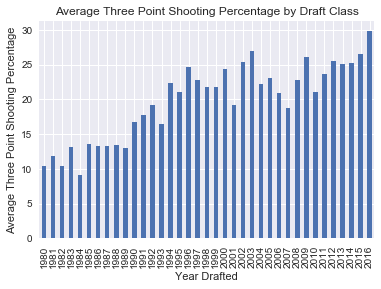

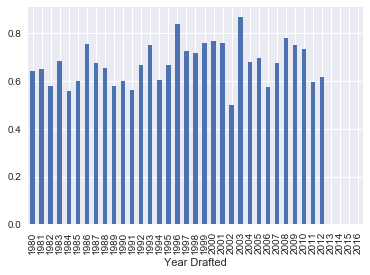

In [6]:
# display averages for 3-point shooting percentages
three_pt = by_year_avg['3P%'].plot(kind='bar')
three_pt.set_ylabel("Average Three Point Shooting Percentage")
three_pt.set_title("Average Three Point Shooting Percentage by Draft Class")

plt.show()

#display percentage of players who played longer than 5 years
target = by_year_avg['TARGET_5Yrs'].plot(kind='bar')
three_pt.set_ylabel("Percentage")
three_pt.set_title("Percentage of Players by Draft Class who Played in the NBA for 5+ Years")

plt.show()

The first plot I included because it is interesting to see the increasing trend of 3-point shooting. The 3-pointer has become a more important factor for a team's offense in the current age of basketball. 
The second plot shows which draft classes showed the percentage of players who played for at least five years in the NBA. The two draft classes with the highest percentage of players playing for at least five years are 1996 and 2003. These draft classes include many hall of fame caliber players, like Kobe Bryant, Allen Iverson, Steve Nash, LeBron James, and Dwyane Wade.

These plots may be useful for my clients to compare new players to the previous players and the quality of each draft class. 

In [7]:
# compute correlation coefficients for efficiency & minutes per game and efficiency & games played

r_eff_mpg = pearson_r(nba_rookie_data['EFF'], nba_rookie_data['MIN'])
print('correlation between efficiency and minutes per game: ', r_eff_mpg)

r_eff_mpg = pearson_r(nba_rookie_data['EFF'], nba_rookie_data['GP'])
print('correlation between efficiency and games played: ', r_eff_mpg)

correlation between efficiency and minutes per game:  0.923406423548
correlation between efficiency and games played:  0.571528114141


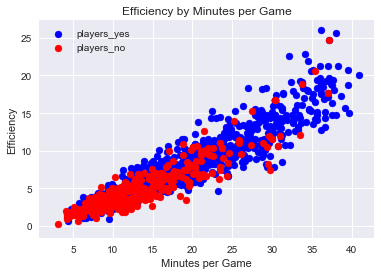

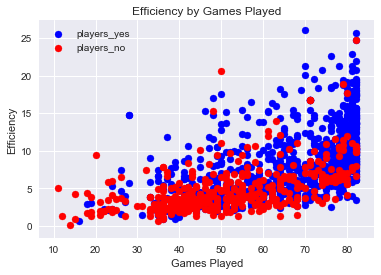

In [8]:
# scatter plots for efficiency by minutes per game and games played

plt.scatter(players_yes['MIN'], players_yes['EFF'], color='b')
plt.scatter(players_no['MIN'], players_no['EFF'], color='r')
plt.xlabel("Minutes per Game")
plt.ylabel("Efficiency")
plt.title("Efficiency by Minutes per Game")
plt.legend(("players_yes", "players_no"))
plt.show()

plt.scatter(players_yes['GP'], players_yes['EFF'], color='b')
plt.scatter(players_no['GP'], players_no['EFF'], color='r')
plt.xlabel("Games Played")
plt.ylabel("Efficiency")
plt.title("Efficiency by Games Played")
plt.legend(("players_yes", "players_no"))
plt.show()

The correlation is high for efficiency and minutes per game, not so much with efficiency and games played. At this point I will turn most of my attention to efficiency and minutes per game because these two stats lead to a good measure of a player's output on the basketball court. 

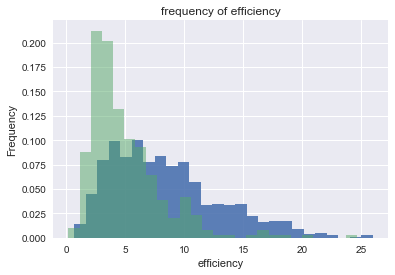

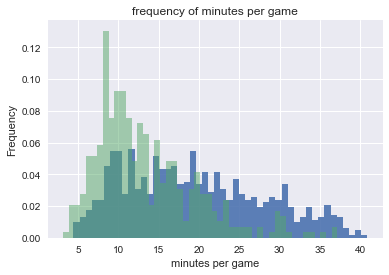

In [9]:
# histogram for efficiency
eff_yes = players_yes['EFF'].plot(kind='hist', normed=True, bins=26, alpha=0.9, label='eff_yes')
eff_no = players_no['EFF'].plot(kind='hist', normed=True, bins=26, alpha=0.5, label='eff_no')

plt.xlabel('efficiency')
plt.title('frequency of efficiency')

plt.show()

# histogram for minutes per game
eff_yes = players_yes['MIN'].plot(kind='hist', normed=True, bins=48, alpha=0.9, label='min_yes')
eff_no = players_no['MIN'].plot(kind='hist', normed=True, bins=48, alpha=0.5, label='min_no')

plt.xlabel('minutes per game')
plt.title('frequency of minutes per game')

plt.show()

In [10]:
# set up the percentiles array
percentiles = np.array([5, 25, 50, 75, 95])

percentiles_eff = np.percentile(players_old['EFF'], percentiles)
print("the percentiles for efficiency are: ", percentiles_eff)

percentiles_min = np.percentile(players_old['MIN'], percentiles)
print("the percentiles for minutes are: ",percentiles_min)

the percentiles for efficiency are:  [  2.1   3.8   6.2   9.8  16.7]
the percentiles for minutes are:  [  6.7    10.4    15.9    22.675  33.7  ]


In [11]:
# percentiles for players who played for at least 5 years 
percentiles_eff = np.percentile(players_yes['EFF'], percentiles)
print("the percentiles for efficiency are: ", percentiles_eff)

percentiles_min = np.percentile(players_yes['MIN'], percentiles)
print("the percentiles for minutes are: ",percentiles_min)

the percentiles for efficiency are:  [  2.5     4.7     7.8    10.9    17.605]
the percentiles for minutes are:  [  7.595  12.1    18.6    25.425  35.21 ]


In [12]:
# percentiles for players who played for less than 5 years
percentiles_eff = np.percentile(players_no['EFF'], percentiles)
print("the percentiles for efficiency are: ", percentiles_eff)

percentiles_min = np.percentile(players_no['MIN'], percentiles)
print("the percentiles for minutes are: ",percentiles_min)

the percentiles for efficiency are:  [  1.7   2.8   4.    6.4  10.6]
the percentiles for minutes are:  [  5.89   8.7   11.75  16.6   25.53]


The percentiles are helpful for identifying what percentage of players from each group lie above a certain percentile marker, especially the spread of players who played longer compared to players who did not play for five years.

In [13]:
# compute the differences of efficiency and minutes per game between players_yes and players_no

difference_efficiency = diff_of_means(players_yes['EFF'], players_no['EFF'])
print('difference of efficiency: ', difference_efficiency)

difference_mpg = diff_of_means(players_yes['MIN'], players_no['MIN'])
print('difference of minutes per game: ', difference_mpg)

difference of efficiency:  3.4612195121951173
difference of minutes per game:  6.055853658536565


There is a significant difference of means for player efficiency and minutes per game. Setting up a hypothesis test will apply a more statistical approach to see if the two groups of players have statistically significant difference between them for the stat categories. 

Null Hypothesis: there is no statistically significant difference between players_yes and players_no.
Alternate Hypothesis: there is a statistically significant difference between players_yes and player_no, enough to convince us that their performance on the court affected their career longevity. 

In [14]:
# compute p-values for efficiency and minutes per game

perm_reps_eff = perm_reps(players_yes['EFF'], players_no['EFF'], diff_of_means, size=10000)
diff_eff = diff_of_means(players_yes['EFF'], players_no['EFF'])
p_eff = p_value(perm_reps_eff, diff_eff)

print('p-value for efficiency = ', p_eff)

perm_reps_minutes = perm_reps(players_yes['MIN'], players_no['MIN'], diff_of_means, size=10000)
diff_minutes = diff_of_means(players_yes['MIN'], players_no['MIN'])
p_minutes = p_value(perm_reps_minutes, diff_minutes)

print('p-value for minutes per game = ', p_minutes)

p-value for efficiency =  0.0
p-value for minutes per game =  0.0


With both p-values equal to 0, we can reject the null hypothesis in favor of the alternative that the two groups of players have statistically significant differences in their performance and ability to play professionally.

With enough information about the two groups of players, we can now start analysis with machine learning. The two algorithms I will use to classify players are logistic regression and K-Nearest Neighbors.

In [15]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(players_old[['EFF', 'MIN']].values, players_old[['TARGET_5Yrs']].values)

# create the logreg classifier
logreg = LogisticRegression()

# fit the classifier to the training data
logreg.fit(X_train, y_train)

# predict the labels of the test set
y_pred = logreg.predict(X_test)

# confusion matrix, classification report, and accuracy score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred, y_test))

[[ 43  69]
 [ 22 174]]
             precision    recall  f1-score   support

          0       0.66      0.38      0.49       112
          1       0.72      0.89      0.79       196

avg / total       0.70      0.70      0.68       308

0.704545454545


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The base accuracy score for logistic regression is 0.7045, or 70.45%. This model correctly identifies players to target "TARGET_5Yrs" given ['EFF', 'MIN'] to players_yes and players_no about 70% of the time. 

In [16]:
# tuning the model using k-fold cross-validation

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

logreg = LogisticRegression()
score = cv_score(logreg, X_train, y_train)
print(score) # score without regularization

0.713666274971


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy increases to 71.37% using k-fold cross-validation for fitting the model.

In [17]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

scores = []

# iterate over C values to choose the highest score
for c in Cs:
    logreg = LogisticRegression()
    logreg.C = c
    #score = cv_score(clf, Xlr, ylr)
    scores.append(cv_score(logreg, X_train, y_train))
    
print("The best C-value is ", Cs[scores.index(max(scores))])

The best C-value is  0.1


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# calculate accuracy on the test data using the C value with the highest score

logreg = LogisticRegression()
logreg.C = Cs[scores.index(max(scores))]
# Fit the model on the training data.
logreg.fit(X_train, y_train)
# Print the accuracy from the testing data.
print(accuracy_score(logreg.predict(X_test), y_test))

0.714285714286


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy is 71.43% when using the best parameter for fitting the model.

In [19]:
# estimate logistic regression accuracy using gridsearchcv
logreg = LogisticRegression()
params = {"C":[0.001, 0.1, 1, 10, 100]}
cv = GridSearchCV(logreg, params)
cv.fit(X_train, y_train)

print("C-value chosen by specifying default scoring on GridSearchCV: ", cv.best_params_['C'])
print("Accuracy: ", accuracy_score(cv.predict(X_test), y_test))

# estimate logistic regression accuracy specifying the cv_score
logreg = LogisticRegression()
params = {"C":[0.001, 0.1, 1, 10, 100]}
cv = GridSearchCV(logreg, params, scoring = cv_score)
cv.fit(X_train, y_train)

print("C-value chosen by specifying cv_score on GridSearchCV: ", cv.best_params_['C'])
print("Accuracy: ", accuracy_score(cv.predict(X_test), y_test))

C-value chosen by specifying default scoring on GridSearchCV:  0.1
Accuracy:  0.714285714286
C-value chosen by specifying cv_score on GridSearchCV:  1
Accuracy:  0.704545454545


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y 

The optimal method for fitting the model to the data is using the default scoring method with GridSearchCV.

The cell with functions below is also from Springboard's logistic regression mini project.

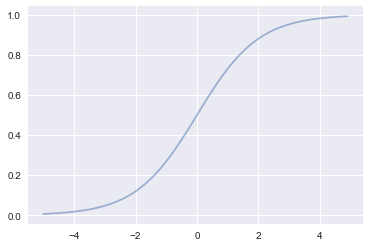

In [20]:
# the code below is set up for classification of the data and supports the math behind how classification is done
# and returns the best classifier to us

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

# we then use the best classifier to fit the entire training set, returning the split data and the trained classifier

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

# sigmoid function for classification

h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.72
Accuracy on test data:     0.71


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


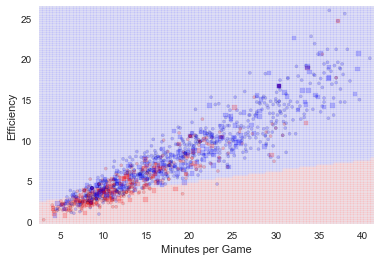

In [21]:
# use do_classify to split data and return the trained classifier

logreg_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           players_old, ['MIN', 'EFF'], 'TARGET_5Yrs',1)

plt.figure()
plt.xlabel("Minutes per Game")
plt.ylabel("Efficiency")
ax = plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, logreg_l, alpha=0.2);

Using the functions from Springboard, accuracy for the training and test data are 0.72 and 0.71.

C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


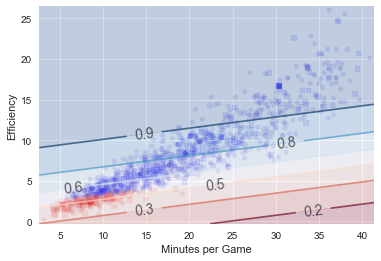

In [22]:
plt.figure()
plt.xlabel("Minutes per Game")
plt.ylabel("Efficiency")
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, logreg_l, psize=20, alpha=0.1);

What this plot illustrates is the decision boundaries between players who play for 5 years and those who do not play for 5 years. To classify a new player, it checks on which side the player is plotted and then makes a prediction. Given efficiency and minutes per game, what is the probability of classifying a rookie player playing in the NBA for at least 5 years?

I will try using KNN and compare accuracy with my results from logistic regression.

C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


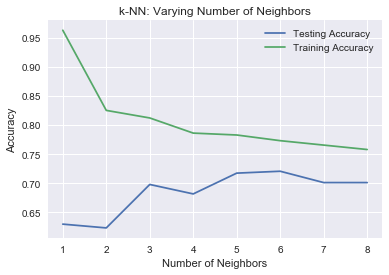

In [23]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(players_old[['EFF', 'MIN']].values, players_old[['TARGET_5Yrs']].values)

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The highest accuracy for the number of neighbors to use for test data is 6 neighbors.

In [26]:
# Create a k-NN classifier with 6 neighbors: knn
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.720779220779


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


The accuracy score for KNN method is 0.7208, or 72.08%. While this score is higher than the scores generated from logistic regression, I think it is a better option to use logistic regression because it returns a probability that a player will play in the NBA for five years given efficiency and minutes per game. 

After my in-depth analysis of the two groups of players who played for at least five years and those who did not, it is very evident that there are significant differences between the groups in terms of talent. Players who played more minutes showed their durability and stamina throughout the game. Players with higher efficiency demonstrate more talent and more contributions to the team while playing. 

For my clients, it is important to consider a player's minute restrictions and overall production. It is not worth investing in a player who is brittle or one who turns the ball over and takes too many shots (and misses). It is also worth noting where a rookie stands compared to other players who were drafted in the same year as them.